# Base station energy optimization using Call Detail Records (CDRs) of Telecom Italia data


CDRs are generated every time when a user communicates to cell towers or base stations. These records are used for billing, call sucess/failure analysis, network optimization, finding users geographical location etc. The analysis in this notebook is done on the data created by Telecom Italia for a big data challenge and data is dowloaded from the following website - 
https://www.nature.com/articles/sdata201555

Voice, SMS and Internet activty of the users in Milan region are analysed and base station power optimization is modelled. Exact base station numbers and GPS information are not available in the data and Square IDs in the data are considered as base stations. Random GPS coordinates within the Milan, Italy region are generated and assigned to base stations. Base stations are divided into clusters and sum of voice and sms activity for off peak hours are analysed per square_id. Low usage base stations are identified for each cluster for off peak hours 12 am to 5 am. Voice and SMS radios can considered to be powered down to save energy.

All 63 datasets containing CDRs for Nov and Dec 2013 were downloaded and used in this notebook.

In [1]:
import time as time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import homogeneity_score, completeness_score, \
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score


dir1='C:\Users\ye543288\Documents\Personal\pythonpractice\Independent Projects\CDR\Files'
file_list=os.listdir(dir1)


In [2]:
len(file_list)

63

## Total SMS and Voice activity 

Total SMS and voice activity is calculated for each dataset aggregated by square id, hour and saved to a csv file. Internet activity is not included as activity is high during night and the radios on the base stations that support  data services need to be powered up during nights

In [ ]:
dataframe=[]
for idx,date in enumerate(file_list):
    filename=os.path.join(dir1,date)
    df=pd.read_csv(filename,header=None,sep='\t')
    df.columns=['square_id','time_interval','country_code','sms_in_activity','sms_out_activity','call_in_activity','call_out_activity','internet_traffic_activity']
    df=df.fillna(0)
    #timeinterval is in epoch time ms. Coverting to Pandas date and time object
    df['datetime']=pd.to_datetime(df.time_interval, unit='ms') 
    df['hour'] = df['datetime'].dt.hour
    df['date'] = df['datetime'].dt.date
    df['sms_voice'] = df['sms_in_activity'] + df['sms_out_activity'] + df['call_in_activity'] + df['call_out_activity']
    df=df.drop(['time_interval','country_code','datetime','date','sms_in_activity','sms_out_activity','call_in_activity','call_out_activity'],axis=1)
    data = df.groupby(['square_id','hour'], as_index=False).aggregate(np.sum)
    dataframe.append(data)

df_all=pd.concat(dataframe)
df_all.to_csv('total_sms_voice_internet.csv',sep=',')

In [2]:
df_all = pd.read_csv('total_sms_voice_internet.csv')
df_all= df_all.drop('Unnamed: 0', axis=1)
df_all.head()

,square_id,hour,internet_traffic_activity,sms_voice
0,1,0,45.332467,2.815604
1,1,1,38.011834,0.636026
2,1,2,33.519783,0.664943
3,1,3,30.743560,0.520838
4,1,4,31.097266,0.344487


Analyse total voice and sms activity for each hour aggregated by square_ids and plot the data to identify off peak hours

In [3]:
df_all=df_all[df_all['sms_voice'] > 0 ] 
df_all=df_all[df_all['internet_traffic_activity'] > 0]

#Exclude hours and square ids with zero activity
df_total_hour = df_all.groupby(['hour'],as_index=False).aggregate(np.sum)
df_total_hour=df_total_hour.drop('square_id',axis=1)#Total sms and voice activty is aggregated per hour

In [4]:
df_total_hour.head()

,hour,internet_traffic_activity,sms_voice
0,0,8.763798e+07,4.593809e+06
1,1,7.558041e+07,2.792427e+06
2,2,6.806289e+07,2.086127e+06
3,3,6.353982e+07,1.854803e+06
4,4,6.332171e+07,2.124902e+06


# Visualization of hourly total internet, voice and sms activity

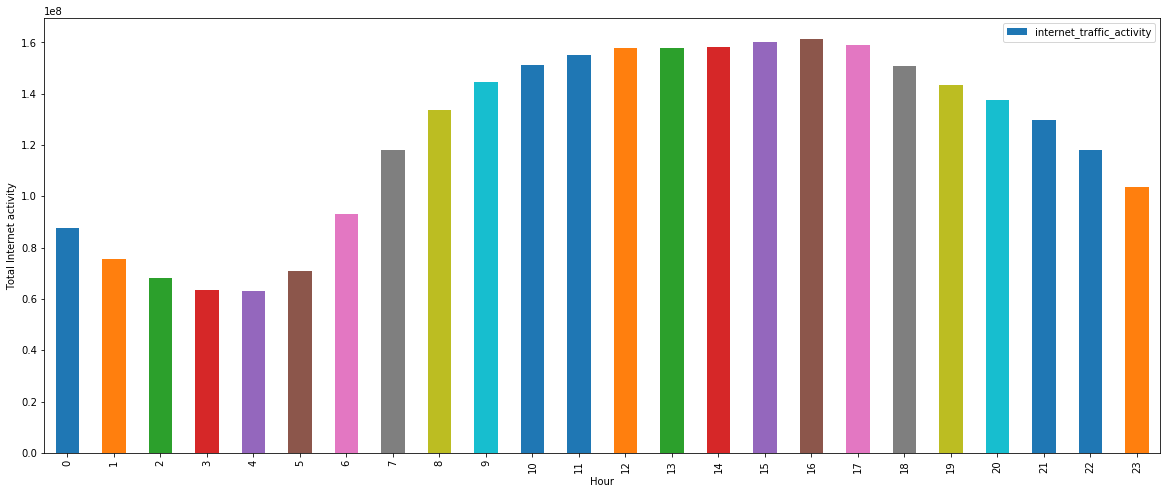

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
df_total_hour.plot(x='hour',y='internet_traffic_activity',linewidth=3.0, figsize=(20,8),xticks=np.arange(0, 24, 1),kind='bar')
plt.xlabel("Hour")
plt.ylabel("Total Internet activity")

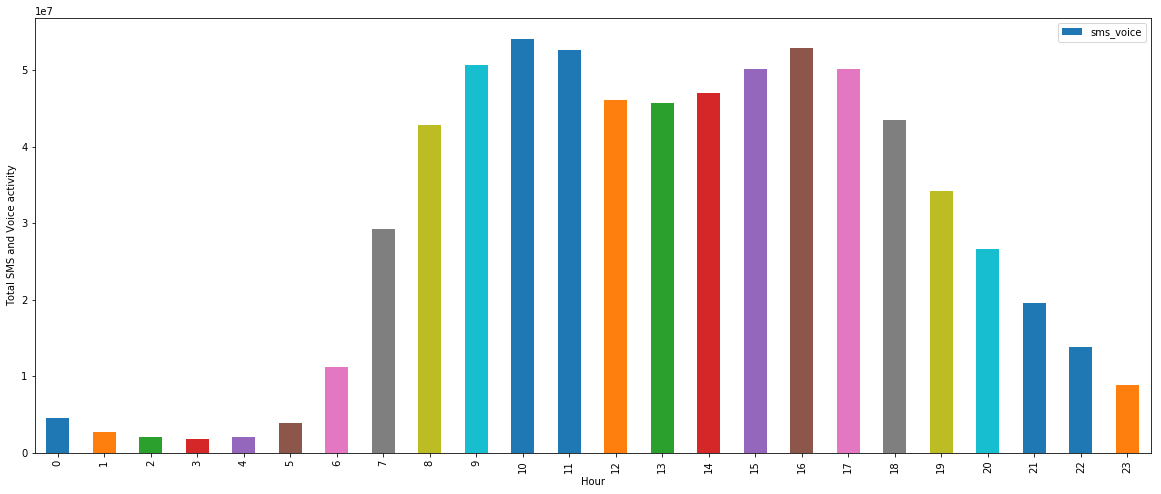

In [6]:

df_total_hour.plot(x='hour',y='sms_voice',linewidth=3.0, figsize=(20,8),xticks=np.arange(0, 24, 1),kind='bar')
plt.xlabel("Hour")
plt.ylabel("Total SMS and Voice activity")

From the figures SMS and Voice activity is nearly 10 times low during mid night and 5:00 am and can be considered as off peak hours. Data is subsetted to include activty from mid night and hourly maximum voice and sms activity is calcualted for each square id.
Internet activity during nights did not decrease during night and optimization cant be perfromed on radio that process internet traffic.

In [7]:
df_voice_sms=df_all[['hour','sms_voice', 'square_id']]
df_night=df_voice_sms[df_voice_sms['hour'].isin([0,1,2,3,4,5])]
sms_voice_night_max=df_night.groupby(['square_id'],as_index=False).aggregate(np.max)
sms_voice_night_max=sms_voice_night_max.drop('hour',axis=1)
sms_voice_night_max.head()

,square_id,sms_voice
0,1,9.219911
1,2,9.294376
2,3,9.373641
3,4,9.004223
4,5,8.193061


# Generating GPS coordinates to cluster the sites based on location

Latitude and longitude low and high are considered based on Milan GPS boundaries. Randomly generated GPS coordinates are sorted and assigned to Cell sites. 

In [8]:
lat = np.random.uniform(low=45.389780, high=45.535372, size=10000)
lat.sort()
longi = np.random.uniform(low=9.064926, high=9.290365, size=10000)
cell_df=pd.DataFrame(range(1,10001))
cell_df.columns=['square_id']
cell_df['lat']=lat
cell_df['long'] = longi
cell_df.to_csv('square_lat_long.csv',sep=',')

In [9]:
#Implement clustering on lat,long and assign cluster to each square id
gps1=pd.read_csv('square_lat_long.csv',index_col=None)
gps1.columns

Index([u'Unnamed: 0', u'square_id', u'lat', u'long'], dtype='object')

In [10]:
gps1=gps1[['square_id', 'lat', 'long']]

In [11]:
gps1.head()

,square_id,lat,long
0,1,45.389781,9.123040
1,2,45.389797,9.104647
2,3,45.389801,9.241423
3,4,45.389810,9.206305
4,5,45.389813,9.219123


Cell sites are clusteed into 1000 clusters based on GPS location using unsupervised clustering algorithm KMeans. Dataset with hourly maximum voice and sms activity values per cell is  merged to dataset with location information and cluster labels. The total maximum activity for all sites and minimum activity for a cell in the cluster are calculated. If all the cells in the cluster can carry the load of the cell having minimum activity that particular cell site can have sms and voice radios powered off during low activity hours. 

In [66]:
from sklearn.cluster import KMeans
start_kmeans = time.time()
kmeans = KMeans(n_clusters=1000, random_state=0).fit(df_combine)
elapsed_kmeans=time.time() - start_kmeans
labels_kmeans = kmeans.predict(df_combine)
df_combine['cluster']=labels_kmeans
gps=df_combine[['square_id','cluster']]
kmeans_centroids = kmeans.cluster_centers_

In [67]:
data=df_combine.drop(['cluster'],axis=1)
silhouette_score(data, df_combine['cluster'], metric='euclidean')

0.079370436921982548

In [69]:
from sklearn.cluster import AgglomerativeClustering
start_agglo = time.time()
agglo = AgglomerativeClustering(n_clusters=1000,linkage = "ward").fit(df_combine) 
elapsed_agglo=time.time() - start_agglo
labels_agglo = agglo.labels_
df_combine['cluster']=agglo.labels_
gps=df_combine[['square_id','cluster']]
                                #using ward minimizes the variance of the clusters being merged                      

In [70]:
data=df_combine.drop(['cluster'],axis=1)
silhouette_score(data, df_combine['cluster'], metric='euclidean')

0.11397730381377996

In [46]:
df_combine=pd.merge(gps1,sms_voice_night_max,on='square_id')

In [47]:
df_combine.head()

,square_id,lat,long,cluster,sms_voice
0,1,45.389781,9.123040,456,9.219911
1,2,45.389797,9.104647,456,9.294376
2,3,45.389801,9.241423,456,9.373641
3,4,45.389810,9.206305,456,9.004223
4,5,45.389813,9.219123,456,8.193061


In [49]:
from sklearn.mixture import GaussianMixture
start_gmm=time.time()
gmm = GaussianMixture(n_components=1000, covariance_type='full').fit(df_combine)
elapsed_gmm= time.time() - start_gmm

In [50]:
clusters = gmm.predict(df_combine)
df_combine['cluster'] = clusters

In [51]:
data = df_combine.drop(['cluster'],axis=1)
silhouette_score(data, clusters, metric='euclidean')

0.025860573641482209

In [71]:
gps = df_combine[['square_id','cluster']]

In [72]:
#Comparision between three algorithms
print "Time Elapsed for Kmeans" , format(elapsed_kmeans)
print "Time Elapsed for Agglomerative" , format(elapsed_agglo)
print "Time Elapsed for GaussianMixture" , format(elapsed_gmm)#,elapsed_agglo,elapsed_gmm

Time Elapsed for Kmeans 22.2470002174
Time Elapsed for Agglomerative 3.1130001545
Time Elapsed for GaussianMixture 51.2869999409


In [73]:
df_combine=pd.merge(gps,sms_voice_night_max,on='square_id')
df_combine.head(10)

,square_id,cluster,sms_voice
0,1,526,9.219911
1,2,526,9.294376
2,3,526,9.373641
3,4,526,9.004223
4,5,526,8.193061
5,6,526,9.373641
6,7,526,9.373641
7,8,526,9.373641
8,9,526,9.373641
9,10,526,5.815946


In [74]:
group_cluster=df_combine.groupby(['cluster'],as_index=False)

In [75]:
sms_voice_cluster=group_cluster.aggregate(np.sum)   #Total maximum hourly activity of all sites in the cluster
sms_voice_cluster_min=group_cluster.aggregate(np.min) #Minimum activity for a cell site in the cluster

In [76]:
sms_voice=pd.merge(sms_voice_cluster,sms_voice_cluster_min,on='cluster')
sms_voice=sms_voice.drop(['square_id_x','square_id_y',],axis=1)
sms_voice=sms_voice.rename(columns={'sms_voice_x': 'sms_voice_cluster_night_total','sms_voice_y': 'sms_voice_cell_min'})

In [77]:
sms_voice.head()

,cluster,sms_voice_cluster_night_total,sms_voice_cell_min
0,0,768.376689,11.736400
1,1,1258.578836,262.702469
2,2,751.847896,10.922360
3,3,928.307398,5.210266
4,4,2136.015248,39.293687


In [78]:
sms_voice_1=pd.merge(sms_voice,df_combine,on='cluster',how='outer')
sms_voice_1.head()

,cluster,sms_voice_cluster_night_total,sms_voice_cell_min,square_id,sms_voice
0,0,768.376689,11.7364,1041,15.917266
1,0,768.376689,11.7364,1042,15.917266
2,0,768.376689,11.7364,1043,15.072080
3,0,768.376689,11.7364,1044,11.736400
4,0,768.376689,11.7364,1045,59.448067


In [79]:
sms_voice_cell_list=sms_voice_1[(sms_voice_1['sms_voice_cell_min'] == sms_voice_1['sms_voice']) 
                        & (sms_voice_1['sms_voice_cluster_night_total'] - sms_voice_1['sms_voice_cell_min'] 
                           > sms_voice_1['sms_voice_cell_min'])  ]
sms_voice_cell_list.head(15)

,cluster,sms_voice_cluster_night_total,sms_voice_cell_min,square_id,sms_voice
3,0,768.376689,11.736400,1044,11.736400
14,1,1258.578836,262.702469,7033,262.702469
36,2,751.847896,10.922360,7614,10.922360
53,3,928.307398,5.210266,7000,5.210266
77,4,2136.015248,39.293687,4622,39.293687
104,5,813.971379,5.592702,6801,5.592702
143,6,2477.456682,70.685140,9376,70.685140
148,7,849.443090,13.261727,9480,13.261727
171,8,1266.051742,88.870850,3576,88.870850
178,9,757.132083,14.835966,7351,14.835966


In [80]:
count_Powerdown_cells = sms_voice_cell_list['square_id'].count()
count_total_cells=sms_voice_1['square_id'].count()
print "Total number of cell sites in the network:%d " %count_total_cells
print "Total number of cell sites that can be powered down :%d " %count_Powerdown_cells
print "Percentage of cell sites that can be powered down from midnight to 5:00 am : %d percent " %(count_Powerdown_cells*100/count_total_cells)

Total number of cell sites in the network:10000 
Total number of cell sites that can be powered down :1028 
Percentage of cell sites that can be powered down from midnight to 5:00 am : 10 percent 


In [81]:
square_gps=pd.merge(sms_voice_cell_list,gps1,on='square_id')
#df_total_hour.plot(x='hour',y='sms_voice',linewidth=3.0, figsize=(20,8),xticks=np.arange(0, 24, 1),kind='scatter')
#plt.xlabel("Hour")
#plt.ylabel("Total SMS and Voice activity")

In [82]:
square_gps=square_gps[['lat','long']]
square_gps[['lat']].count()

lat    1028
dtype: int64

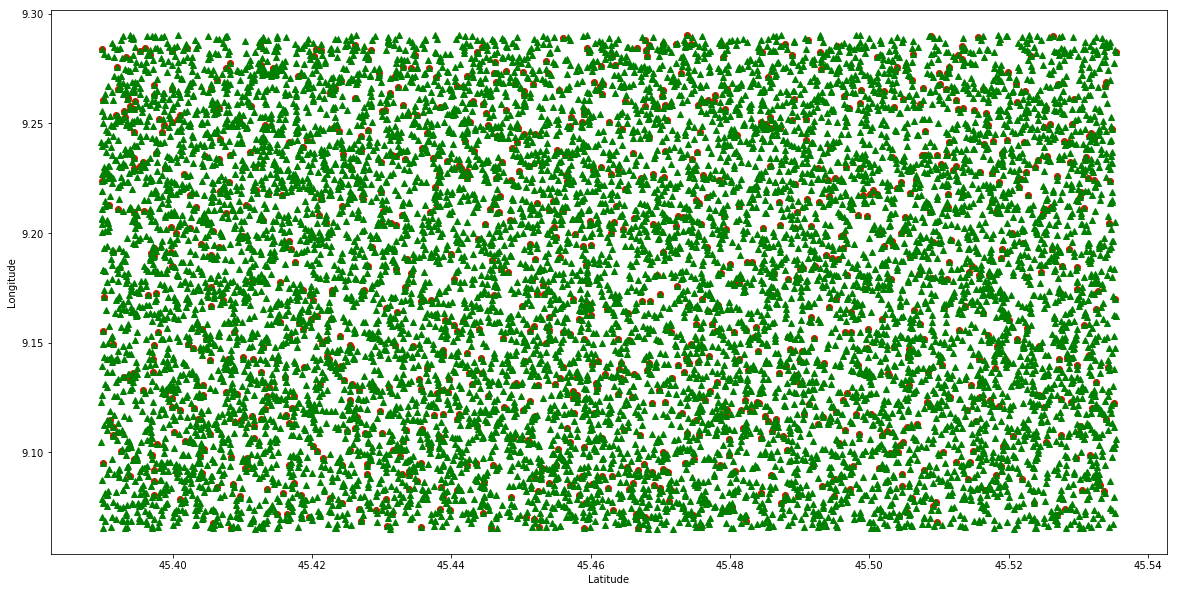

In [83]:
#plt =plt.gcf()
plt.figure(figsize=(20,10))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.plot(square_gps['lat'],square_gps['long'],'ro',gps1['lat'],gps1['long'],'g^')
#plt.xticks(range(44,45.55,0.1))
#gps1.plot(x='lat',y='long',kind='scatter',colormap='copper')